In [6]:
import argparse
import os
import platform
import sys
from pathlib import Path
import torch

ROOT = "yolov5/"

sys.path.append(ROOT)

from models.common import DetectMultiBackend
from utils.dataloaders import IMG_FORMATS, VID_FORMATS, LoadImages, LoadScreenshots, LoadStreams
from utils.general import (LOGGER, Profile, check_file, check_img_size, check_imshow, check_requirements, colorstr, cv2,
                           increment_path, non_max_suppression, print_args, scale_boxes, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, smart_inference_mode

In [7]:
from platform import python_version

print(python_version())

3.9.12


In [9]:
class yoloDetect():
    def __init__(self, weights=os.path.join(ROOT, 'runs/train/exp/weights/best.pt')):
        device='cpu'
        dnn=False
        data=os.path.join(ROOT, 'data/coco128.yaml')
        half=False
        imgsz=(640, 640)
        
        self.device = select_device(device)
        self.model = DetectMultiBackend(weights, device=self.device, dnn=dnn, data=data, fp16=half)
        self.stride, self.names, self.pt = self.model.stride, self.model.names, self.model.pt
        self.imgsz = check_img_size(imgsz, s=self.stride)
        
        
    def run(self,
            source,    
            conf_thres=0.25, 
            iou_thres=0.45,  # NMS IOU threshold
            max_det=1000,  # maximum detections per image
            view_img=False,  # show results
            save_txt=False,  # save results to *.txt
            save_conf=False,  # save confidences in --save-txt labels
            save_crop=False,  # save cropped prediction boxes
            nosave=False,  # do not save images/videos
            classes=None,  # filter by class: --class 0, or --class 0 2 3
            agnostic_nms=False,  # class-agnostic NMS
            augment=False,  # augmented inference
            visualize=False,  # visualize features
            update=False,  # update all models
            project='runs/detect',  # save results to project/name
            name='exp',  # save results to project/name
            exist_ok=False,  # existing project/name ok, do not increment
            line_thickness=3,  # bounding box thickness (pixels)
            hide_labels=False,  # hide labels
            hide_conf=False,  # hide confidences
            vid_stride=1):
    
        source = str(source)
        name_ = source.split("/")[-1].split(".")[0]
        save_img = not nosave and not source.endswith('.txt')  # save inference images
        is_file = Path(source).suffix[1:] in (IMG_FORMATS + VID_FORMATS)
        is_url = source.lower().startswith(('rtsp://', 'rtmp://', 'http://', 'https://'))
        webcam = source.isnumeric() or source.endswith('.txt') or (is_url and not is_file)
        screenshot = source.lower().startswith('screen')
        if is_url and is_file:
            source = check_file(source) 






        if webcam:
            view_img = check_imshow()
            dataset = LoadStreams(source, img_size=self.imgsz, stride=self.stride, auto=self.pt, vid_stride=vid_stride)
        elif screenshot:
            dataset = LoadScreenshots(source, img_size=self.imgsz, stride=self.stride, auto=self.pt)
        else:
            dataset = LoadImages(source, img_size=self.imgsz, stride=self.stride, auto=self.pt, vid_stride=vid_stride)
        bs = len(dataset)  # batch_size
        vid_path, vid_writer = [None] * bs, [None] * bs

        # Run inference
        self.model.warmup(imgsz=(1 if self.pt or self.model.triton else bs, 3, *self.imgsz))  # warmup
        seen, windows, dt = 0, [], (Profile(), Profile(), Profile())
        for path, im, im0s, vid_cap, s in dataset:
            with dt[0]:
                im = torch.from_numpy(im).to(self.model.device)
                im = im.half() if self.model.fp16 else im.float()  # uint8 to fp16/32
                im /= 255  # 0 - 255 to 0.0 - 1.0
                if len(im.shape) == 3:
                    im = im[None]  # expand for batch dim


            with dt[1]:
                visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
                pred = self.model(im, augment=augment, visualize=visualize)


            with dt[2]:
                pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)


            # Process predictions
            for i, det in enumerate(pred):  # per image
                seen += 1
                if webcam:  # batch_size >= 1
                    p, im0, frame = path[i], im0s[i].copy(), dataset.count
                    s += f'{i}: '
                else:
                    p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)

                p = Path(p)  # to Path
#                 txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # im.txt
                s += '%gx%g ' % im.shape[2:]  # print string
                gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
                imc = im0.copy() if save_crop else im0  # for save_crop
                annotator = Annotator(im0, line_width=line_thickness, example=str(self.names))
                if len(det):
                    # Rescale boxes from img_size to im0 size
                    det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()

                    # Print results
                    for c in det[:, 5].unique():
                        n = (det[:, 5] == c).sum()  # detections per class
                        s += f"{n} {self.names[int(c)]}{'s' * (n > 1)}, "  # add to string

                    # Write results
                    for *xyxy, conf, cls in reversed(det):
                        if save_txt:  # Write to file
                            xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                            line = (cls, *xywh, conf) if save_conf else (cls, *xywh)  # label format
                            with open(f'{txt_path}.txt', 'a') as f:
                                f.write(('%g ' * len(line)).rstrip() % line + '\n')

                        if save_img or save_crop or view_img:  # Add bbox to image
                            c = int(cls)  # integer class
                            label = None if hide_labels else (self.names[c] if hide_conf else f'{self.names[c]} {conf:.2f}')
                            annotator.box_label(xyxy, label, color=colors(c, True))
                        if save_crop:
                            save_one_box(xyxy, imc, file=save_dir / 'crops' / names[c] / f'{p.stem}.jpg', BGR=True)

                # Stream results
                im0 = annotator.result()
        saving_path = f"static/img/{name_}.png"
        cv2.imwrite(saving_path, im0)
        return name_

In [12]:
y1 = yoloDetect()

YOLOv5  v6.2-162-g55fbac9 Python-3.9.12 torch-1.12.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients


In [18]:
path = "C:/Users/Admin/Downloads/yoloV5_prediction/yolov5/test_img/0000097_11819_d_0000055.jpg"

In [29]:
img_ = y1.run(path)

In [30]:
cv2.imwrite("tt1223t.jpg", img_)

False

# .py Class Test

In [21]:
from yolo_class import *

In [22]:
y1 = yoloDetect()

YOLOv5  v6.2-162-g55fbac9 Python-3.9.12 torch-1.12.1+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7037095 parameters, 0 gradients


In [33]:
path = "C:/Users/Admin/Downloads/yoloV5_prediction/yolov5/test_img/0000097_11819_d_0000055.jpg"

In [41]:
img_ = y1.run(path)

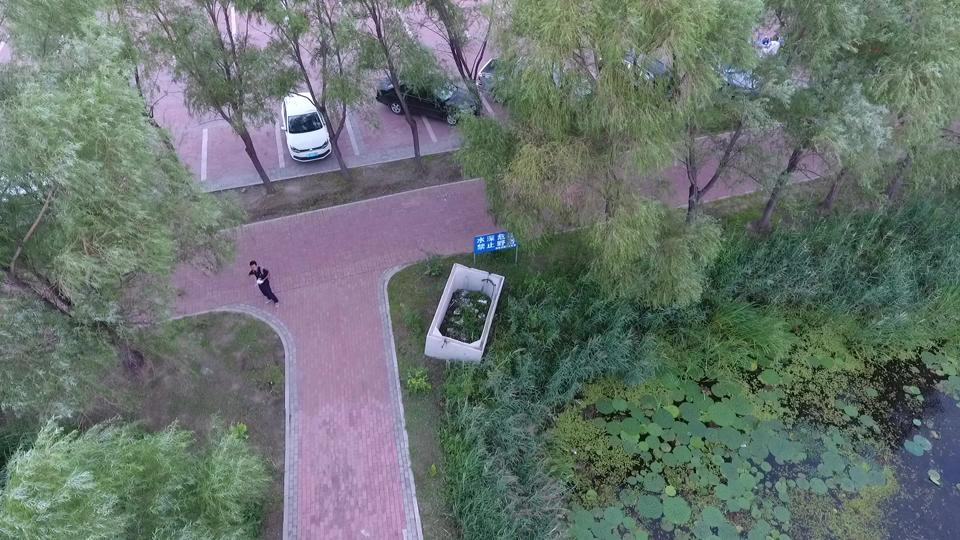

In [49]:
from IPython.display import Image
Image(filename=path) 


In [50]:
img_

'0000097_11819_d_0000055'

In [51]:
cv2.imwrite("hello_1.jpg", img_)

False